In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import HelperFunctions as hf


In [153]:
def load_data():
    calendar = hf.load_calendar_data()
    sell_price = hf.load_sell_price_data()
    sales_evaluation = hf.load_sales_train_evaluation_data()
    sales_validation = hf.load_sales_train_validation_data()

    print('Loading data Done.')
    return calendar, sell_price, sales_evaluation, sales_validation


def combine_data(calendar, sell_price, sales_validation, day_cut=1500, merge=False):
    '''
    convert wide data format to long data format, 
    merge data to a single dataframe
    get data that have 'd_' >= 1500
    '''
   
    # melt
    sales_train = pd.melt(sales_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = 'sold')

    # remove duplicates
    sales_train = sales_train.drop_duplicates()
   
    # since there are too many rows, it's essential to take part of the data to reduce the computation time 
    data = sales_train[sales_train['d'].str.replace('d_', '').astype('int16') > day_cut]
    
    # merge
    if merge:
        data = pd.merge(data, calendar, on='d', how='left')
        data = pd.merge(data, sell_price, on=['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

    print('Combining data Done.')
    return data


def clean_data(data):
    # null values
    events_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for f in events_features:
        data[f].fillna('unknown', inplace = True)


    # impute with the mean value
    data["sell_price"].fillna(data.groupby("id")["sell_price"].transform("mean"), inplace=True)
    

    # drop useless columns
 
    print('Cleaning data Done.')

    
def transform_data(data):
    # lag features
    lags = [7, 14, 28, 35]
    for lag in lags:
        data["lag_" + str(lag)] = data.groupby("id")["sold"].shift(lag).astype('float16')   


    # rolling mean features
    window=28
    for period in [7, 14, 28, 35]:
        data['rolling_mean_' + str(period)] = data.groupby('id')['sold'].transform(lambda x: x.shift(window).rolling(period).mean()).astype('float16')


    # time features
    data['date'] = pd.to_datetime(data['date'])
    data['day'] = data['date'].dt.day.astype('int16')
    data['weekends'] = np.where(data['date'].dt.dayofweek < 5, 0, 1)
    data.drop(columns=["wm_yr_wk", 'weekday', "date"], inplace=True)


    # remove NaN due to lag and rolling
    data = data.dropna()
    
    # categorical
    cat = ['dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        fea = pd.get_dummies(data[feature], prefix=feature)
        data = pd.concat([data, fea], axis=1)
        data = data.drop([feature], axis=1)

    labelencoder = LabelEncoder()
    data['item_id_cat'] = labelencoder.fit_transform(data['item_id'])

    print('Feature engineering Done.')
    return data

def reduce_memory(data):
    data['d'] = data['d'].str.replace('d_', '').astype('int16')
    data[['month', 'year', 'wday', 'weekends']] = data[['month', 'year', 'wday', 'weekends']].astype('int16')

    data['sold'] = data['sold'].astype("int16")
    data["sell_price"] = data["sell_price"].astype("float16")
    data["item_id_cat"] = data["item_id_cat"].astype("int16")

    data[["snap_CA", "snap_TX", "snap_WI"]] = data[["snap_CA", "snap_TX", "snap_WI"]].astype("int8")

    print('Reduce memory Done.')



## Load the data

In [154]:
calendar, sell_price, sales_evaluation, sales_validation = load_data()

pre_data = combine_data(calendar, sell_price, sales_validation, merge=True)


Loading data Done.
Combining data Done.


In [155]:
pre_data.to_csv('./data/combined_data.csv', index=False)


In [94]:
# pre_data = pd.read_csv('./data/combined_data.csv')


## Preprocessing

In [156]:

clean_data(pre_data)

pre_data = transform_data(pre_data)

reduce_memory(pre_data)


Cleaning data Done.
Feature engineering Done.
Reduce memory Done.


In [157]:
pre_data.to_csv('./data/transformed_data.csv', index=False)


In [158]:
# pre_data = pd.read_csv('./data/transformed_data.csv')


In [159]:
pre_data.head()


,id,item_id,d,sold,wday,month,year,snap_CA,snap_TX,snap_WI,...,event_name_1_VeteransDay,event_name_1_unknown,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_unknown,event_name_2_unknown,event_type_2_unknown,item_id_cat
1890380,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,1563,0,2,5,2015,1,0,0,...,0,0,1,0,0,0,0,1,1,1437
1890381,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,1563,0,2,5,2015,1,0,0,...,0,0,1,0,0,0,0,1,1,1438
1890382,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,1563,0,2,5,2015,1,0,0,...,0,0,1,0,0,0,0,1,1,1439
1890383,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,1563,4,2,5,2015,1,0,0,...,0,0,1,0,0,0,0,1,1,1440
1890384,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,1563,0,2,5,2015,1,0,0,...,0,0,1,0,0,0,0,1,1,1441


## Cut item

In [160]:
from sklearn.utils import resample

statify = pre_data['item_id'].str.extract(r'([a-z|A-Z]+)(.+)')[0]


In [161]:
# sample 1000 items

sampled_item_ids = resample(pre_data['item_id'], n_samples=1000, replace=False, stratify=statify, random_state=0)

sampled_data = pre_data[pre_data['item_id'].isin(sampled_item_ids)]


In [170]:
sampled_data.to_csv('./data/sampled_data_1000.csv', index=False)


In [163]:
# sampled_data = pd.read_csv('./data/sampled_data_1000.csv')


## Split train-test

In [164]:
d_start = 1913 - 28

train_set = pre_data[pre_data['d'] <= d_start]
test_set = pre_data[(pre_data['d'] > d_start)]

X_train = train_set[train_set.columns[train_set.columns != 'sold']]
y_train = train_set['sold']

X_test = test_set[test_set.columns[test_set.columns != 'sold']]
y_test = test_set['sold']


X_train = X_train.loc[:, ~X_train.columns.isin(['id', 'd', 'item_id'])]
X_test = X_test.loc[:, ~X_test.columns.isin(['id', 'd', 'item_id'])]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((9848270, 76), (9848270,), (853720, 76), (853720,))

## Loss

In [165]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def rmse(y_t, y_p):
    return np.sqrt(mean_squared_error(y_t, y_p))


## Linear regression

In [166]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_train_predicted = lin_reg.predict(X_train)
print('train rmse error', rmse(y_train_predicted, y_train))

y_test_predicted = lin_reg.predict(X_test)
print('test rmse error', rmse(y_test_predicted, y_test))


train rmse error 2.2689557
test rmse error 2.101456


In [167]:

lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

display_scores(np.sqrt(-lin_scores))


Scores: [2.34733328 2.5142556  2.20140171 2.18651548 2.22372534 2.10560905
 2.35293944 2.32275468 2.26508256 2.21341515]
Mean: 2.273303228938095
Standard deviation: 0.1092068110162377


In [168]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = lin_reg, 
    X = X_train,
    y = y_train, 
    train_sizes=np.linspace(.1, 1.0, 10),
    cv = 5, scoring = 'neg_mean_squared_error')



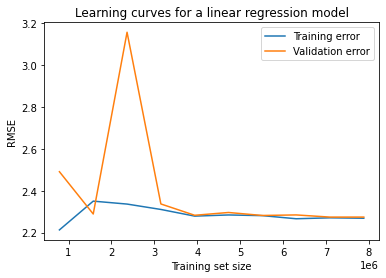

In [169]:
train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
validation_scores_mean = np.sqrt(-validation_scores).mean(axis =1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('RMSE')
plt.xlabel('Training set size')
plt.title('Learning curves for a linear regression model')
plt.legend()
plt.show()


- high bias


In [ ]:

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train,y_train)

y_train_predicted = knn.predict(X_train)
print('train rmse error', rmse(y_train_predicted, y_train))

y_test_predicted = knn.predict(X_test)
print('test rmse error', rmse(y_test_predicted, y_test))

lin_scores = cross_val_score(knn, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

display_scores(np.sqrt(-lin_scores))


train rmse error 1.9816290090742759
test rmse error 2.1708239279733252


## XGBoost

In [ ]:
import xgboost as xgb

params = {
    'tree_method': 'gpu_hist', 
    'max_depth': 3, 
    'learning_rate': 0.1
}

xgb.train(params, dtrain)
xgb_reg = xgb(params) 
xb = xgb_reg.fit(X_train,y_train)
y_pred=xgb_reg.predict(X_test)


In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "RMSE",]
x.add_row(["Linear Regression (Baseline)", 2])
x.add_row(["KNNRegressor", 7])
x.add_row(["XGBRegressor", 2291, 5205,97.23 ])

print(x)

## Fine-Tune
